In [ ]:
from zipfile import ZipFile
file_name = '/content/archive.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
!pip install tensorflow

cuda
Epoch [1/50], Loss: 0.0661
Epoch [2/50], Loss: 0.0731
Epoch [3/50], Loss: 0.0597
Epoch [4/50], Loss: 0.0526
Epoch [5/50], Loss: 0.0248
Epoch [6/50], Loss: 0.0164
Epoch [7/50], Loss: 0.0194
Epoch [8/50], Loss: 0.0153
Epoch [9/50], Loss: 0.0148
Epoch [10/50], Loss: 0.0177
Epoch [11/50], Loss: 0.0159
Epoch [12/50], Loss: 0.0134
Epoch [13/50], Loss: 0.0149
Epoch [14/50], Loss: 0.0119
Epoch [15/50], Loss: 0.0137
Epoch [16/50], Loss: 0.0156
Epoch [17/50], Loss: 0.0130
Epoch [18/50], Loss: 0.0098
Epoch [19/50], Loss: 0.0118
Epoch [20/50], Loss: 0.0129
Epoch [21/50], Loss: 0.0108
Epoch [22/50], Loss: 0.0125
Epoch [23/50], Loss: 0.0110
Epoch [24/50], Loss: 0.0151
Epoch [25/50], Loss: 0.0081
Epoch [26/50], Loss: 0.0087
Epoch [27/50], Loss: 0.0085
Epoch [28/50], Loss: 0.0078
Epoch [29/50], Loss: 0.0105
Epoch [30/50], Loss: 0.0085
Epoch [31/50], Loss: 0.0090
Epoch [32/50], Loss: 0.0088
Epoch [33/50], Loss: 0.0090
Epoch [34/50], Loss: 0.0068
Epoch [35/50], Loss: 0.0091
Epoch [36/50], Loss: 0.0

<Figure size 1600x1200 with 0 Axes>

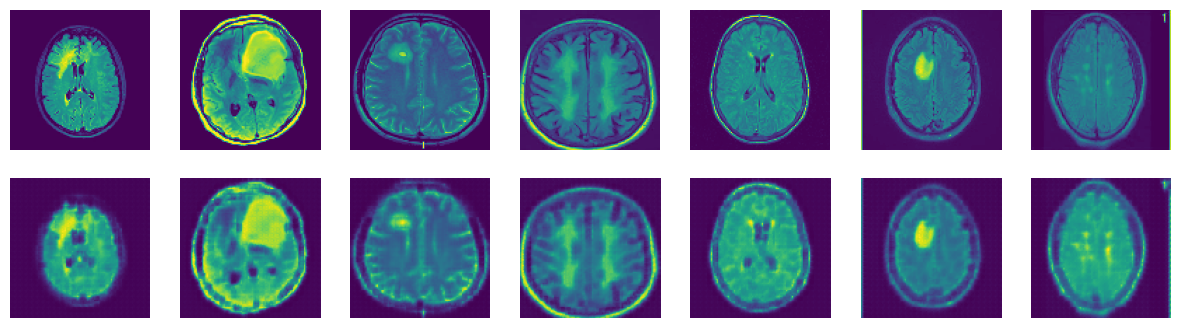

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image



yes_dir = '/content/yes'
no_dir = '/content/no'

# Function to load images and assign labels
def load_images_and_labels(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):
            img_path = os.path.join(directory, filename)
            img = image.load_img(img_path, target_size=(100, 100), color_mode='grayscale')
            img_array = image.img_to_array(img)
            img_array /= 255.0  # Normalize pixel values
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load 'yes' images
yes_images, yes_labels = load_images_and_labels(yes_dir, 1)

# Load 'no' images
no_images, no_labels = load_images_and_labels(no_dir, 0)

# Concatenate 'yes' and 'no' images and labels
images = np.concatenate([yes_images, no_images], axis=0)
labels = np.concatenate([yes_labels, no_labels], axis=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
reshaped_x_train = x_train.transpose(0, 3, 1, 2)
x_train_tensor = torch.from_numpy(reshaped_x_train).float()
reshaped_x_test = x_test.transpose(0,3,1,2)
x_test_tensor = torch.from_numpy(reshaped_x_test).float()
x_train_tensor = x_train_tensor.to(device)
x_test_tensor = x_test_tensor.to(device)

# Assuming labels are already in the correct format

y_train_tensor = torch.from_numpy(y_train)
y_test_tensor = torch.from_numpy(y_test)

class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()  # Assuming input images are normalized between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def get_encoded_representation(self, x):
        return self.encoder(x)

# Assuming x_train and x_test are tensors with shape (num_samples, 1, height, width)
latent_dim = 2048
autoencoder = Autoencoder(latent_dim).to(device)


# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 50
batch_size = 32

train_dataset = TensorDataset(x_train_tensor,y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for data in train_loader:
        inputs = data[0]
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing the autoencoder
test_dataset = TensorDataset(x_test_tensor,y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

with torch.no_grad():
    for data in test_loader:
        inputs = data[0]
        outputs = autoencoder(inputs)
        # You can visualize the original and reconstructed images here
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = autoencoder(data)
        break

import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

X_train = x_train.reshape(len(x_train),-2)
X_test = x_test.reshape(len(x_test),-2)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
from sklearn.cluster import MiniBatchKMeans
total_clusters = len(np.unique(y_train))
# Initialize the K-Means model
kmeans = MiniBatchKMeans(n_clusters = total_clusters,random_state=42)
# Fitting the model to training set
kmeans.fit(X_train_scaled)

kmeans.labels_

def retrieve_info(cluster_labels,y_train):
 #‘’’
 #Associates most probable label with each cluster in KMeans model
# returns: dictionary of clusters assigned to each label

# Initializing
  reference_labels = {}
# For loop to run through each label of cluster label
  for i in range(len(np.unique(kmeans.labels_))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

reference_labels = retrieve_info(kmeans.labels_,y_train)
number_labels = np.random.rand(len(kmeans.labels_))
for i in range(len(kmeans.labels_)):
  number_labels[i] = reference_labels[kmeans.labels_[i]]

print(np.unique(number_labels))
print(number_labels[:20].astype('int'))
print(y_train[:20])

from sklearn.metrics import accuracy_score
print(accuracy_score(number_labels,y_train))
print(adjusted_rand_score(number_labels,y_train))


[0. 1.]
[0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1]
[0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 0]
0.5955882352941176
0.03252037751692697


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index (Autoencoder): 0.0032277587250353038
Normalized Mutual Information (Autoencoder): 0.007678054377455558
Accuracy: 0.5514705882352942
0.18278235
-0.029245276


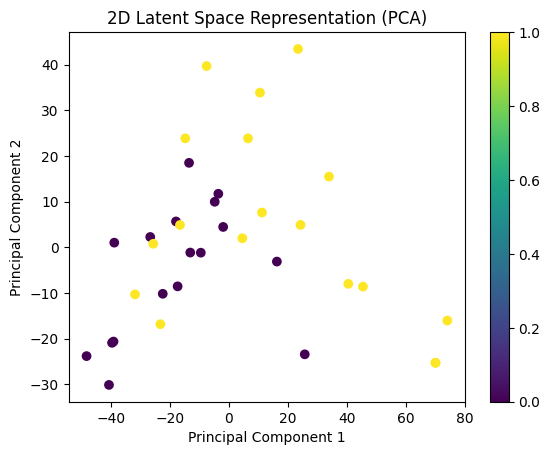

In [ ]:
# Assuming autoencoder is your trained autoencoder model
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def extract_latent_space(model, data_loader, device):
    model.eval()
    latent_space = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            encoded = model.encoder(inputs)
            latent_space.append(encoded.view(encoded.size(0), -1).cpu())

    return torch.cat(latent_space, dim=0)

# Extract latent space representation
latent_representation = extract_latent_space(autoencoder, train_loader, device)
from sklearn.cluster import KMeans

# Assuming total_clusters is the desired number of clusters
kmeans2 = KMeans(n_clusters=total_clusters, random_state=42)
cluster_labels_autoencoder = kmeans2.fit_predict(latent_representation)

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari_autoencoder = adjusted_rand_score(y_train, cluster_labels_autoencoder)
nmi_autoencoder = normalized_mutual_info_score(y_train, cluster_labels_autoencoder)

print(f"Adjusted Rand Index (Autoencoder): {ari_autoencoder}")
print(f"Normalized Mutual Information (Autoencoder): {nmi_autoencoder}")

# Assuming cluster_labels_autoencoder and y_test are numpy arrays
# Perform label matching using the Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(-confusion_matrix(cluster_labels_autoencoder, y_train))

# Match cluster labels to true labels
matched_labels_autoencoder = col_ind[cluster_labels_autoencoder]

# Calculate accuracy
accuracy = accuracy_score(matched_labels_autoencoder, y_train)
print(f"Accuracy: {accuracy}")

from sklearn.metrics import silhouette_score

silhouette_autoencoder = silhouette_score(latent_representation, cluster_labels_autoencoder)
silhouette_kmeans = silhouette_score(latent_representation, number_labels)

print(silhouette_autoencoder)
print(silhouette_kmeans)

from sklearn.decomposition import PCA

# Assuming you have an autoencoder instance named 'autoencoder'
# and a dataset X_test that you want to visualize
encoded_data = autoencoder.get_encoded_representation(x_test_tensor)

# Extract the numpy array from the PyTorch tensor
encoded_data_np = encoded_data.reshape(encoded_data.size(0), -1).detach().cpu().numpy()

# Perform PCA for dimensionality reduction to 2D
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(encoded_data_np)

# Plot the 2D latent space
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_test, cmap='viridis')
plt.title('2D Latent Space Representation (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.5, random_state=42)
# scale data
X_train1 = X_train.reshape(len(X_train),-2)
X_test1 = X_test.reshape(len(X_test),-2)
t = StandardScaler()
t.fit(X_train1)
X_train2 = t.transform(X_train1)
X_test2 = t.transform(X_test1)

model = RandomForestClassifier(random_state=42)
model.fit(X_train2,Y_train)
y_hat = model.predict(X_test2)
print(accuracy_score(Y_test,y_hat))

reshaped_X_train = X_train.transpose(0, 3, 1, 2)
X_train_tensor = torch.from_numpy(reshaped_X_train).float()
reshaped_X_test = X_test.transpose(0,3,1,2)
X_test_tensor = torch.from_numpy(reshaped_X_test).float()

X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
X_train_encode = autoencoder.get_encoded_representation(X_train_tensor)
X_test_encode = autoencoder.get_encoded_representation(X_test_tensor)

X_train_encode_2d = X_train_encode.reshape(X_train_encode.size(0), -1).detach().cpu().numpy()
X_test_encode_2d = X_test_encode.reshape(X_test_encode.size(0), -1).detach().cpu().numpy()
t.fit(X_train_encode_2d)
X_train_encode_2d = t.transform(X_train_encode_2d)
X_test_encode_2d = t.transform(X_test_encode_2d)


model.fit(X_train_encode_2d,Y_train)
y_hat_new = model.predict(X_test_encode_2d)
print(accuracy_score(Y_test,y_hat_new))

0.7441860465116279
0.813953488372093
